In [ ]:
# install
!pip install -q cadl
!apt-get install -q imagemagick

Reading package lists...
Building dependency tree...
Reading state information...
imagemagick is already the newest version (8:6.9.7.4+dfsg-16ubuntu6.8).
0 upgraded, 0 newly installed, 0 to remove and 21 not upgraded.


In [ ]:
# imports
import glob
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import json
import seaborn as sns
import requests
from cadl import utils, gif
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from skimage.transform import resize
from sklearn.decomposition import IncrementalPCA as PCA
from sklearn.manifold import TSNE
from umap import UMAP
from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment
from google.colab import drive

In [ ]:
# file stuff
drive.mount('/content/drive')
files = glob.glob("/content/drive/My Drive/UCLA/F20-171/cyanotypes/tiff/all/cropped/*-col2*.jpg")
len(files)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


448

In [ ]:
cyanotypes = []
for cyano in files:
  cyanotype = plt.imread(cyano)
  #cyanotype = cyanotype[..., :3]
  cyanotype = utils.imcrop_tosquare(cyanotype)
  cyanotype = resize(cyanotype, (256, 256))
  cyanotypes.append(cyanotype)

cyanotypes_np = np.array(cyanotypes)

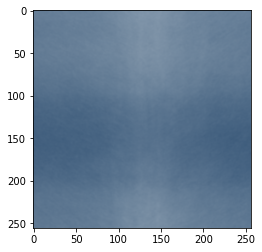

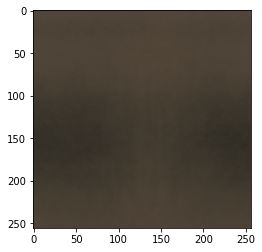

In [ ]:
mean_img = np.mean(cyanotypes_np, axis=0)
std_img = np.std(cyanotypes_np, axis=0)

plt.imshow(mean_img)
plt.figure()
plt.imshow(std_img)

In [ ]:
# add -3 and +3 standard deviations to mean image
model = [mean_img + i * std_img for i in np.linspace(-3, 3, 100)]

# normalize each image from 0 to 1
model = [(cyano - np.min(cyano)) / np.ptp(cyano) for cyano in model]

# make gif
gif.build_gif(model)

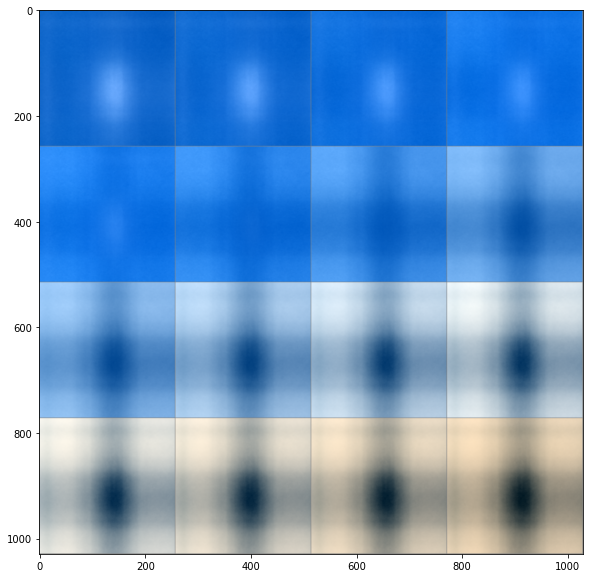

In [ ]:
# make montage
montage_model = [model[cyano] for cyano in np.linspace(0, 99, 16).astype(int)]
montage = utils.montage(montage_model)

# plot montage
plt.figure(figsize=(10,10))
plt.imshow(montage)

In [ ]:
# load Inception model
net = tf.keras.applications.InceptionV3()
net.trainable = False

# get activations of layers
names = ['avg_pool', 'predictions']
layers = [net.get_layer(name).output for name in names]

# create feature extraction model
model = tf.keras.Model(inputs=net.input, outputs=layers)

96116736/96112376 [==============================] - 1s 0us/step


float64 0.01568627450980392 0.9411764705882353 (256, 256, 3)


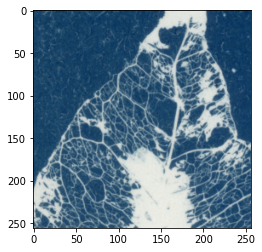

In [ ]:
# sanity check
cyanotype = cyanotypes[0]
plt.imshow(cyanotype)
print(cyanotype.dtype, cyanotype.min(), cyanotype.max(), cyanotype.shape)

In [ ]:
# load Inception model
net = tf.keras.applications.InceptionV3()
net.trainable = False

# get activations of layers
names = ['avg_pool', 'predictions']
layers = [net.get_layer(name).output for name in names]

# create feature extraction model
model = tf.keras.Model(inputs=net.input, outputs=layers)

In [ ]:
# download labels
response = requests.get("https://git.io/JJkYN")
labels = response.text.split("\n")
print(labels)

['tench', 'goldfish', 'great white shark', 'tiger shark', 'hammerhead', 'electric ray', 'stingray', 'cock', 'hen', 'ostrich', 'brambling', 'goldfinch', 'house finch', 'junco', 'indigo bunting', 'robin', 'bulbul', 'jay', 'magpie', 'chickadee', 'water ouzel', 'kite', 'bald eagle', 'vulture', 'great grey owl', 'European fire salamander', 'common newt', 'eft', 'spotted salamander', 'axolotl', 'bullfrog', 'tree frog', 'tailed frog', 'loggerhead', 'leatherback turtle', 'mud turtle', 'terrapin', 'box turtle', 'banded gecko', 'common iguana', 'American chameleon', 'whiptail', 'agama', 'frilled lizard', 'alligator lizard', 'Gila monster', 'green lizard', 'African chameleon', 'Komodo dragon', 'African crocodile', 'American alligator', 'triceratops', 'thunder snake', 'ringneck snake', 'hognose snake', 'green snake', 'king snake', 'garter snake', 'water snake', 'vine snake', 'night snake', 'boa constrictor', 'rock python', 'Indian cobra', 'green mamba', 'sea snake', 'horned viper', 'diamondback', 

In [ ]:
# get activations for all cyanotypes
activations = model(
    tf.keras.applications.inception_v3.preprocess_input(
        (cyanotypes_np * 255)
    )
)

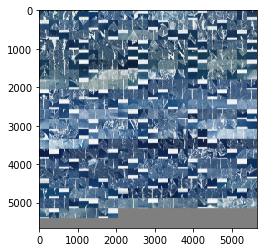

In [ ]:
# montage all cyanotypes
montage = utils.montage(cyanotypes_np)
plt.imshow(montage)

In [ ]:
# ask for most confident predictions and convert to numpy array
preds = activations[-1].numpy()
[labels[cyano] for cyano in preds.argmax(axis=1)]

['head cabbage',
 'head cabbage',
 'head cabbage',
 'jellyfish',
 'doormat',
 'doormat',
 'head cabbage',
 'quill',
 'quill',
 'spider web',
 'spider web',
 'head cabbage',
 'head cabbage',
 'head cabbage',
 'head cabbage',
 'quill',
 'pillow',
 'head cabbage',
 'quill',
 'head cabbage',
 'bonnet',
 'doormat',
 'doormat',
 'brassiere',
 'head cabbage',
 'head cabbage',
 'quill',
 'doormat',
 'doormat',
 'head cabbage',
 'quill',
 'fig',
 'head cabbage',
 'doormat',
 'umbrella',
 'head cabbage',
 'head cabbage',
 'head cabbage',
 'quill',
 'ski',
 'birdhouse',
 'head cabbage',
 'quill',
 'skunk',
 'head cabbage',
 'killer whale',
 'doormat',
 'head cabbage',
 'head cabbage',
 'black and gold garden spider',
 'killer whale',
 'doormat',
 'bath towel',
 'head cabbage',
 'head cabbage',
 'head cabbage',
 'head cabbage',
 'doormat',
 'doormat',
 'head cabbage',
 'head cabbage',
 'head cabbage',
 'head cabbage',
 'doormat',
 'doormat',
 'head cabbage',
 'quill',
 'skunk',
 'head cabbage',
 '

In [ ]:
# extract features
features = activations[0].numpy()
features.shape
features

array([[0.32615826, 0.00729015, 0.06955424, ..., 0.90815175, 1.3196192 ,
        0.9456174 ],
       [0.58329535, 0.21176417, 0.15911613, ..., 1.9036353 , 2.0746489 ,
        0.89311886],
       [0.60419476, 0.39640805, 0.20426682, ..., 0.72455806, 1.1554288 ,
        0.25183994],
       ...,
       [0.46011898, 0.31374106, 0.01516026, ..., 0.18353292, 1.0652022 ,
        1.2597306 ],
       [0.39982784, 0.14208853, 0.14158824, ..., 0.4643612 , 0.353048  ,
        0.19051132],
       [0.8647907 , 0.09588463, 0.14842537, ..., 0.23117383, 0.        ,
        0.95083565]], dtype=float32)

In [ ]:
# get features for each network
features_2d_pca = PCA(n_components=2).fit_transform(X=features)
features_2d_tsne = TSNE(n_components=2).fit_transform(X=features)
features_2d_umap = UMAP(n_components=2).fit_transform(X=features)

Text(0.5, 1.0, 'UMAP')

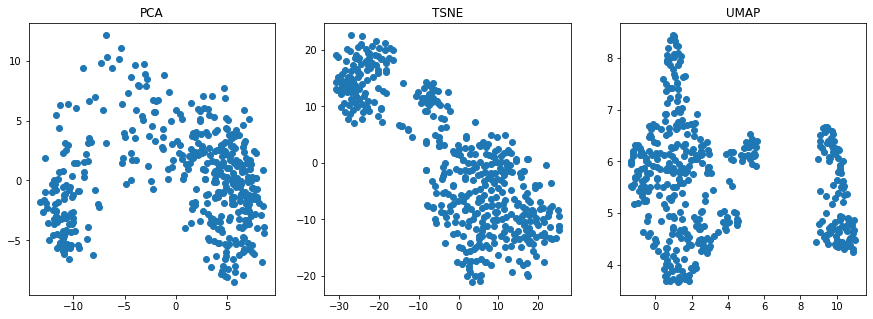

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].scatter(features_2d_pca[:, 0], features_2d_pca[:, 1])
axs[0].set_title("PCA")
axs[1].scatter(features_2d_tsne[:, 0], features_2d_tsne[:, 1])
axs[1].set_title("TSNE")
axs[2].scatter(features_2d_umap[:, 0], features_2d_umap[:, 1])
axs[2].set_title("UMAP")

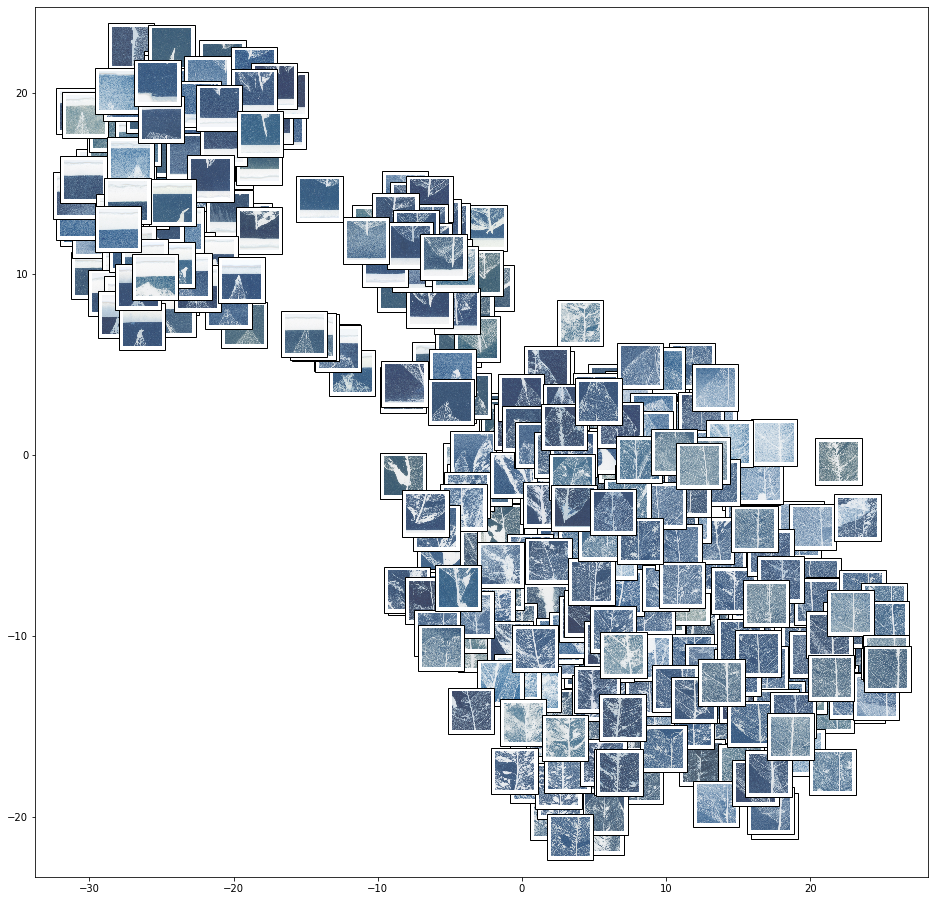

In [ ]:
zoom = 0.15
features_2d = features_2d_tsne
# features_2d = features_2d_pca

fig, ax = plt.subplots(figsize=(16, 16))
for i, img in enumerate(cyanotypes_np):
  img_box = OffsetImage(img, zoom=zoom, alpha=0.8)
  xy = (features_2d[i][0], features_2d[i][1])
  ab = AnnotationBbox(img_box, xy, xycoords='data')
  ax.add_artist(ab)
  ax.update_datalim([xy])
  ax.autoscale()

In [ ]:
# number of images
n_imgs = len(cyanotypes_np)

# create a grid that spans the range of values of our projected 2D features
indexes = np.linspace(np.min(features_2d) * 2.0, np.max(features_2d) * 2.0, int(np.ceil(np.sqrt(n_imgs))))
xs, ys = np.meshgrid(indexes, indexes)

# grid could be larger than necessary, slice it to the number of images
grid = np.dstack((ys, xs)).reshape(-1, 2)[:n_imgs,:]

# visualize assignment
fig, axs = plt.subplots(1, 2, figsize=(8, 3))
axs[0].scatter(features_2d[:, 0], features_2d[:, 1], edgecolors='none', marker='o', s=2)
axs[0].set_title('TSNE Embedding')
axs[1].scatter(grid[:,0], grid[:,1],
               edgecolors='none', marker='o', s=2)
axs[1].set_title('Idealized Grid')

In [ ]:
# calculate new indexes
cost = cdist(grid[:, :], features_2d[:, :], 'sqeuclidean')
indexes = linear_sum_assignment(cost)

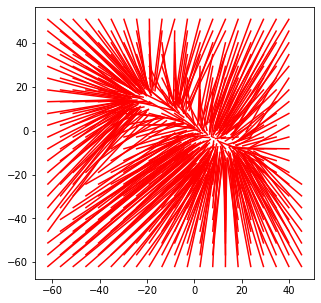

In [ ]:
plt.figure(figsize=(5, 5))
for i in range(n_imgs):
  plt.plot([features_2d[indexes[1][i], 0], grid[i, 0]],
           [features_2d[indexes[1][i], 1], grid[i, 1]], 'r')

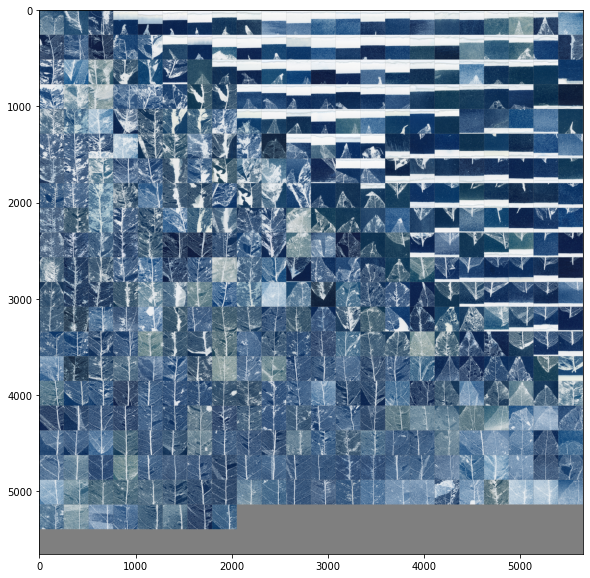

In [ ]:
sorted = [cyanotypes_np[cyano] for cyano in indexes[1]]
montage = utils.montage(sorted)
plt.figure(figsize=(10, 10))
plt.imshow(montage)

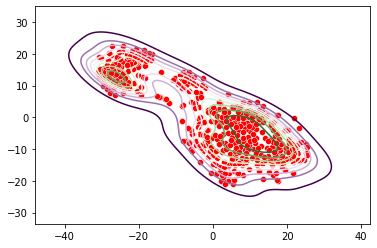

In [ ]:
#x_features = features_2d_pca[:,0]
#y_features = features_2d_pca[:,1]
x_features = features_2d_tsne[:,0]
y_features = features_2d_tsne[:,1]

x_min, x_max = x_features.min()-1, x_features.max()+1
y_min, y_max = y_features.min()-1, y_features.max()+1

x, y = np.meshgrid(np.arange(x_min, x_max, 0.2),
                   np.arange(y_min, y_max, 0.2))

df = pd.DataFrame(features_2d_pca)

fig, ax = plt.subplots()
#sns.kdeplot(x=features_2d_pca[:,0], y=features_2d_pca[:,1], cmap="PRGn", ax=ax)
#sns.scatterplot(x=features_2d_pca[:,0], y=features_2d_pca[:,1], color="red", ax=ax)
sns.kdeplot(x=features_2d_tsne[:,0], y=features_2d_tsne[:,1], cmap="PRGn", ax=ax)
sns.scatterplot(x=features_2d_tsne[:,0], y=features_2d_tsne[:,1], color="red", ax=ax)
plt.show()